### Loading data..

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# --- 1. Load and Preprocess the Churn Dataset ---
path="C:/Users/SAYHI/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1"
path+="/WA_Fn-UseC_-Telco-Customer-Churn.csv"
print("--- 1. Data Loading and Initial Inspection ---")
# Load the dataset (Assuming the file is available in the environment)
try:
    df = pd.read_csv(path)
except FileNotFoundError:
    print("Error: The file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' was not found.")
    exit()

print(f"Initial dataset shape: {df.shape}")

--- 1. Data Loading and Initial Inspection ---
Initial dataset shape: (7043, 21)


### Handling missing values

In [100]:
# Convert TotalCharges to numeric. Missing values are represented by ' ' in the raw data.
# The 'coerce' argument will turn non-numeric values (like ' ') into NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing data in TotalCharges (impute with median or drop).
# Given the small number of missing values, we will drop them for simplicity.
df.dropna(subset=['TotalCharges'], inplace=True)
print(f"Shape after handling TotalCharges NaNs: {df.shape}")

# Drop customerID as it is just an identifier and not a feature
df.drop('customerID', axis=1, inplace=True)

# Encode the target variable 'Churn'
# Yes -> 1 (Positive class); No -> 0 (Negative class)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Shape after handling TotalCharges NaNs: (7032, 21)


### Encoding categorical values

In [101]:
# --- Preprocessing Categorical Features ---

# 1. Standardize / simplify categorical values (e.g., replace 'No internet service' with 'No')
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    df[col] = df[col].replace('No internet service', 'No')

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

# 2. Binary Encoding (Map 'Yes'/'Male' to 1 and 'No'/'Female' to 0)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'gender', 'MultipleLines'] + service_cols

# Map 'Yes' to 1, 'No' to 0
for col in binary_cols:
    if col != 'gender':
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    else:
        # For gender, map 'Male' to 1 and 'Female' to 0
        df[col] = df[col].map({'Male': 1, 'Female': 0})

# 3. One-Hot Encoding for remaining nominal columns
# These include InternetService, Contract, and PaymentMethod
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

# 4. Scale Numerical Features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\n--- Preprocessing Complete ---")
print(f"Final dataset shape for modeling: {df.shape}")


--- Preprocessing Complete ---
Final dataset shape for modeling: (7032, 24)


### EDA


--- 2. Exploratory Data Analysis (EDA) ---
Overall Churn Rate: 26.58%


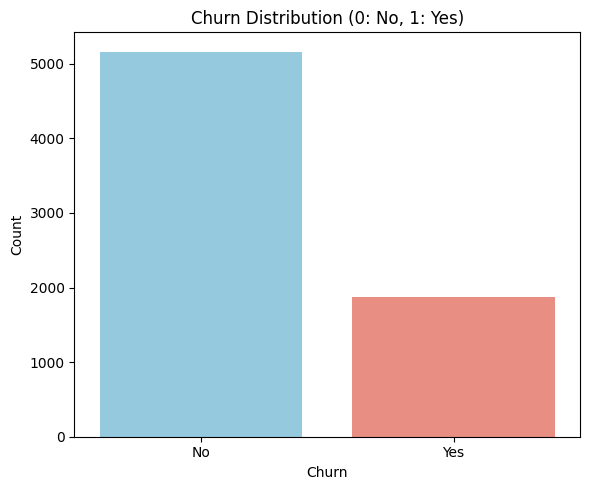

In [102]:
# Overall Churn Rate
print("\n--- 2. Exploratory Data Analysis (EDA) ---")
churn_rate = df['Churn'].mean()
print(f"Overall Churn Rate: {churn_rate:.2%}")

# Visualize Churn Distribution with meaningful, distinct colors
plt.figure(figsize=(6, 5))
sns.countplot(
    x='Churn',
    data=df,
    palette={'0': 'skyblue', '1': 'salmon'}  # 0 = No churn, 1 = Yes churn
)
plt.title('Churn Distribution (0: No, 1: Yes)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])  # Optional: show class labels instead of 0/1
plt.tight_layout()
plt.show()



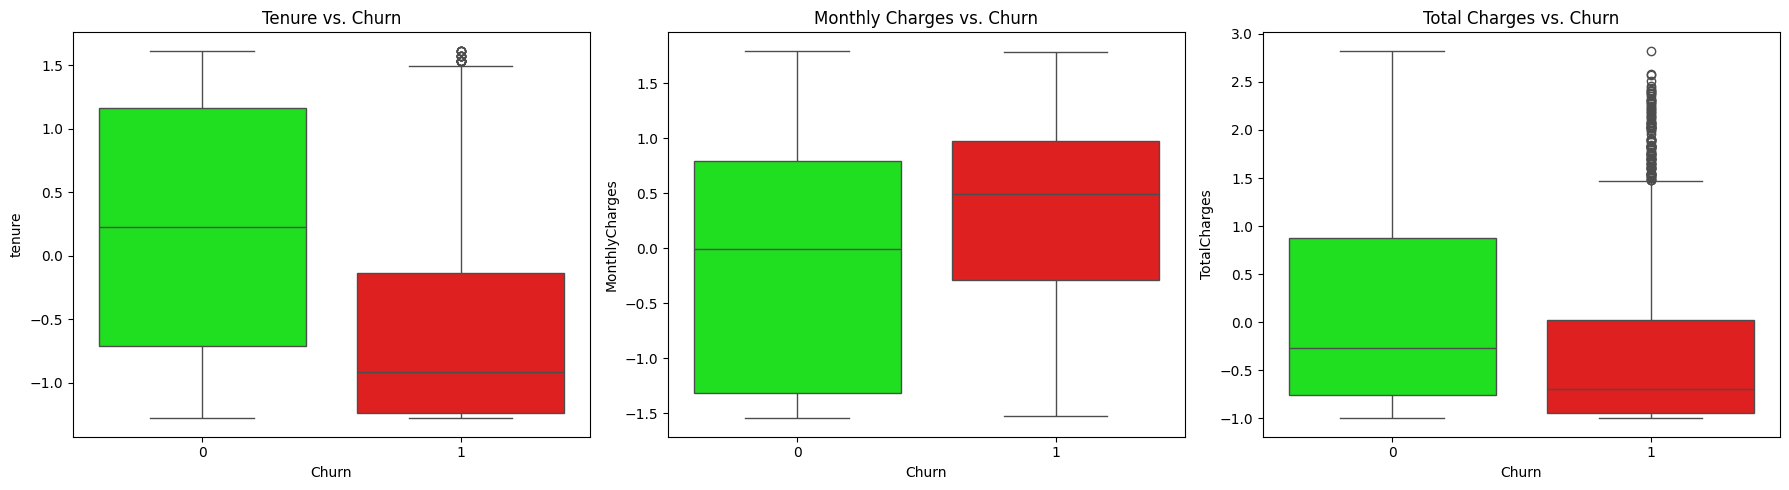

In [103]:
# Define consistent color palette for Churn classes
churn_palette = {'1': 'red', '0': 'lime'}  # 0 = No churn, 1 = Yes churn

# Create boxplots with color distinction
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0], palette=churn_palette)
axes[0].set_title('Tenure vs. Churn')

sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette=churn_palette)
axes[1].set_title('Monthly Charges vs. Churn')

sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[2], palette=churn_palette)
axes[2].set_title('Total Charges vs. Churn')

plt.tight_layout()
plt.show()


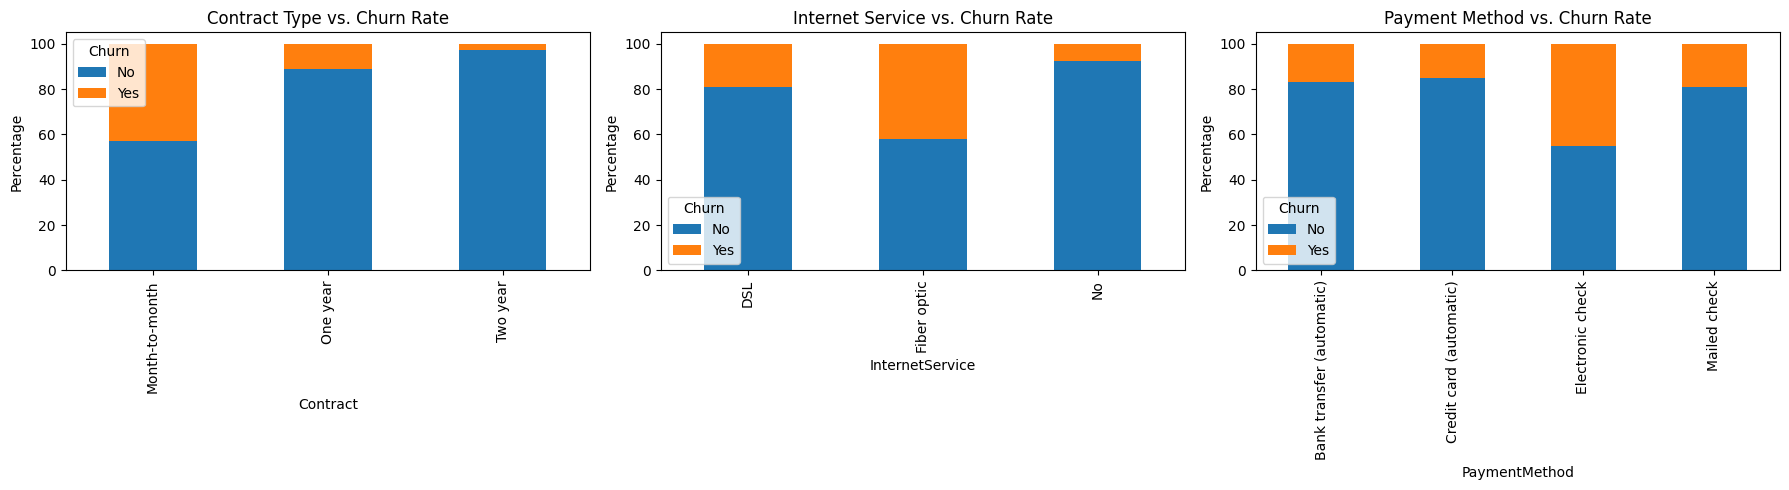

In [104]:
# Visualize key categorical features vs. Churn (using unscaled/unencoded data for better visualization)
df_raw = pd.read_csv(path)
df_raw['TotalCharges'] = pd.to_numeric(df_raw['TotalCharges'], errors='coerce')
df_raw.dropna(subset=['TotalCharges'], inplace=True)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Contract vs Churn
contract_churn = df_raw.groupby('Contract')['Churn'].value_counts(normalize=True).mul(100).unstack().plot(
    kind='bar', stacked=True, ax=axes[0], title='Contract Type vs. Churn Rate'
)
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Churn', labels=['No', 'Yes'])

# Internet Service vs Churn
internet_churn = df_raw.groupby('InternetService')['Churn'].value_counts(normalize=True).mul(100).unstack().plot(
    kind='bar', stacked=True, ax=axes[1], title='Internet Service vs. Churn Rate'
)
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Churn', labels=['No', 'Yes'])

# Payment Method vs Churn
payment_churn = df_raw.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).mul(100).unstack().plot(
    kind='bar', stacked=True, ax=axes[2], title='Payment Method vs. Churn Rate'
)
axes[2].set_ylabel('Percentage')
axes[2].legend(title='Churn', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

### Class imbalance via SMOTE

In [105]:
# --- 3. Address Class Imbalance (SMOTE) & Data Split ---

X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size before SMOTE (Positive Class): {y_train.sum()} / {len(y_train)} ({y_train.mean():.2%})")

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set size after SMOTE (Positive Class): {y_train_resampled.sum()} / {len(y_train_resampled)} ({y_train_resampled.mean():.2%})")


Training set size before SMOTE (Positive Class): 1402 / 5274 (26.58%)
Training set size after SMOTE (Positive Class): 3872 / 7744 (50.00%)


### Train Models

In [106]:
# --- 4 & 5. Train and Evaluate Multiple Classification Models ---

def evaluate_model(model, X_test, y_test, model_name):
    """Trains, predicts, and evaluates a single model."""
    print(f"\n--- Evaluating {model_name} ---")

    # Predict probabilities for ROC AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(classification_report(y_test, y_pred))

    # Visualize confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Dictionary to store model results
model_results = []
models = {}

### 1. Logistic Regression


--- Evaluating Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1291
           1       0.51      0.75      0.60       467

    accuracy                           0.74      1758
   macro avg       0.70      0.74      0.71      1758
weighted avg       0.79      0.74      0.75      1758



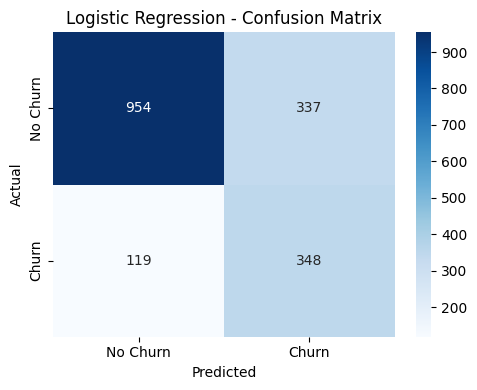

In [107]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
models['Logistic Regression'] = log_reg
model_results.append(evaluate_model(log_reg, X_test, y_test, 'Logistic Regression'))

### 2. Random Forest (class-weight)


--- Evaluating Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1291
           1       0.62      0.48      0.54       467

    accuracy                           0.78      1758
   macro avg       0.72      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758



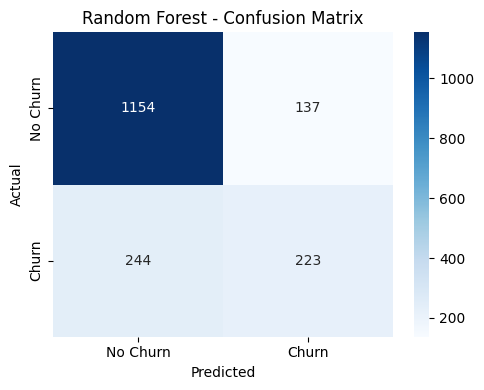

In [108]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train) # Using original X_train for RF, as it handles imbalance via class_weight
models['Random Forest'] = rf_clf
model_results.append(evaluate_model(rf_clf, X_test, y_test, 'Random Forest'))

### 3. XGBoost Classifier


--- Evaluating XGBoost ---
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1291
           1       0.54      0.65      0.59       467

    accuracy                           0.76      1758
   macro avg       0.70      0.73      0.71      1758
weighted avg       0.78      0.76      0.77      1758



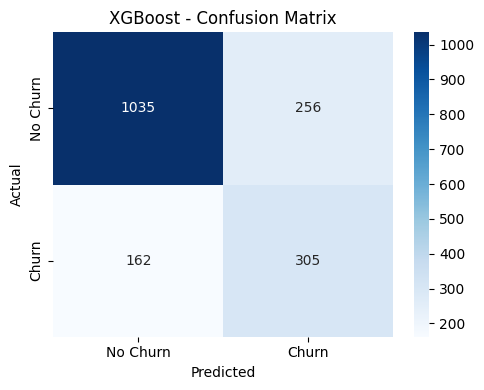

In [109]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)
models['XGBoost'] = xgb_clf
model_results.append(evaluate_model(xgb_clf, X_test, y_test, 'XGBoost'))

In [110]:
# --- 6. Analyze Feature Importance and Provide Insights ---

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(model_results).set_index('Model')
print("\n--- Model Comparison Summary ---")
print(results_df.round(4))


--- Model Comparison Summary ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.7406     0.5080  0.7452    0.6042   0.8272
Random Forest          0.7833     0.6194  0.4775    0.5393   0.8169
XGBoost                0.7622     0.5437  0.6531    0.5934   0.8065



--- Feature Importance (XGBoost) ---
InternetService_Fiber optic       0.2992
InternetService_No                0.2058
Contract_Two year                 0.1437
Contract_One year                 0.0513
PaymentMethod_Electronic check    0.0372
tenure                            0.0266
TechSupport                       0.0254
OnlineSecurity                    0.0235
StreamingMovies                   0.0229
OnlineBackup                      0.0171
dtype: float32


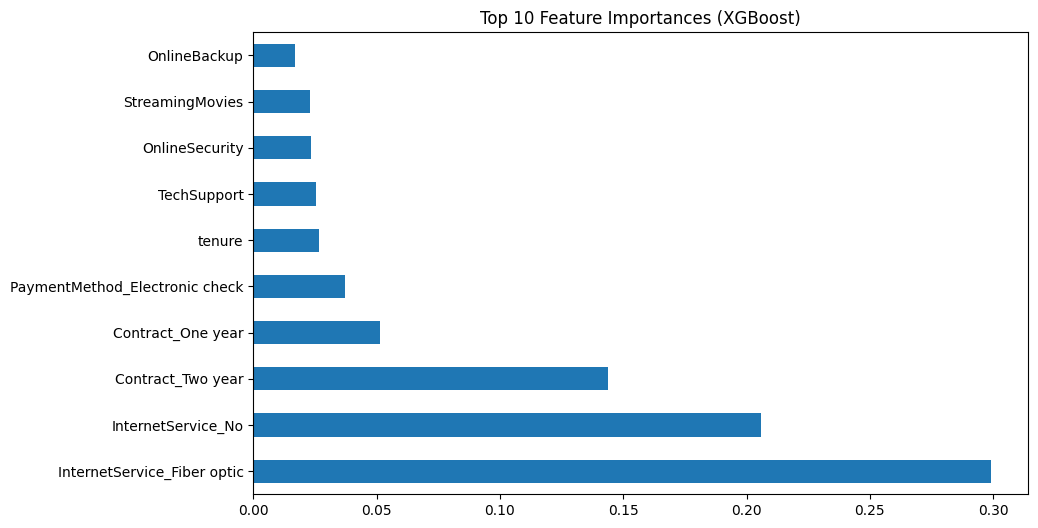

In [114]:
# Choose XGBoost (often the best performer) for Feature Importance Analysis
best_model = models['XGBoost']
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("\n--- Feature Importance (XGBoost) ---")
print(feature_importances_sorted.head(10).round(4))

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
feature_importances_sorted.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

Feature Importance Insights:
1. InternetService_Fiber optic (Importance: 0.2992): This is the most crucial factor.
   - Strategy: 'Fiber optic' users are more likely to churn, possibly due to higher expectations, competition, or service quality issues. Targeted efforts on improving this service segment or customer support are needed.
2. Contract_Two year (Importance: 0.1437):
   - Strategy: Customers with 'Month-to-month' contracts are highly volatile. Offering incentives for longer contracts (One/Two Year) is critical.

Recommendation: Focus retention efforts primarily on customers with Month-to-month contracts and Fiber Optic internet service who are within their first year of service.